# **Facial Detection System**

Ensuring that AI systems are fair and unbiased is important for their long-term adoption and trust. Facial detection, which determines whether an image contains a face, is a seemingly straightforward but significantly important task that might suffer from significant algorithmic bias across different demographic groups.

In this project, we will develop a facial detection model that learns the latent variables within face image datasets and uses this information to adaptively resample the training data.

This approach leads to reducation in biases and a more equitable model to train.



# **Import Libraries**

In [46]:
import tensorflow as tf
import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense
import tensorflow as tf
import functools

# **Datasets**


To train our facial detection models, we require a dataset of positive examples (i.e., faces) and a dataset of negative examples (i.e., non-faces). These datasets will enable us to train our models to distinguish between images of faces and non-faces. Additionally, we need a test dataset of face images. Since we are concerned about potential bias in our models against certain demographics, it is crucial that the test dataset is equally representative of the demographics or features of interest. Skin tone and gender will be focused in this analysis.

1. **Positive training data**: [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) - A large-scale dataset containing over 200,000 images of celebrity faces.
2. **Negative training data**: [ImageNet](http://www.image-net.org/) - A diverse dataset with images across various categories. We will extract negative examples from different non-human categories.
3. **Test data**: The test dataset will be labeled according to the [Fitzpatrick Scale](https://en.wikipedia.org/wiki/Fitzpatrick_scale) skin type classification system, with each image categorized as "Lighter" or "Darker".


In [32]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [33]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

In [36]:
images.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(100, 64, 64, 3)

In [43]:
images[1:2]

array([[[[0.52156866, 0.59607846, 0.654902  ],
         [0.5176471 , 0.5921569 , 0.6509804 ],
         [0.5137255 , 0.5882353 , 0.64705884],
         ...,
         [0.09803922, 0.0627451 , 0.03529412],
         [0.10196079, 0.06666667, 0.03921569],
         [0.09411765, 0.06666667, 0.04313726]],

        [[0.5176471 , 0.5921569 , 0.6509804 ],
         [0.5137255 , 0.5882353 , 0.64705884],
         [0.50980395, 0.58431375, 0.6431373 ],
         ...,
         [0.09019608, 0.05490196, 0.02745098],
         [0.09411765, 0.05882353, 0.03137255],
         [0.09019608, 0.0627451 , 0.03921569]],

        [[0.5137255 , 0.5882353 , 0.64705884],
         [0.50980395, 0.58431375, 0.6431373 ],
         [0.5058824 , 0.5803922 , 0.6392157 ],
         ...,
         [0.09411765, 0.05882353, 0.03137255],
         [0.09803922, 0.0627451 , 0.03529412],
         [0.09019608, 0.0627451 , 0.03137255]],

        ...,

        [[0.37254903, 0.41568628, 0.43137255],
         [0.36862746, 0.4117647 , 0.42745098]

In [37]:
labels.shape

(100, 1)

In [39]:
labels[1:5]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

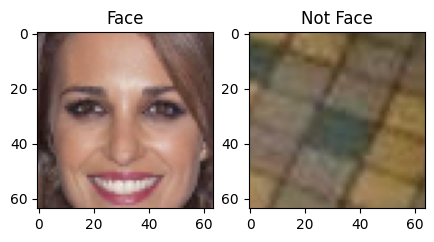

In [45]:
#Examining the CelebA training dataset
# Separate face and not-face images based on labels
face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

# Define indices for face and not-face images to display
idx_face = 13 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 26 #@param {type:"slider", min:0, max:50, step:1}

# Plot the selected face and not-face images
plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

##**CNN for Facial Detection**

Define and train a CNN for the task of facial classification and assess its accuracy. Later on, we will compare the performance of our debiased models with this baseline CNN. The CNN architecture is fairly standard, comprising a sequence of convolutional layers with batch normalization, followed by two fully connected layers that flatten the convolution output to generate a class prediction.


In [47]:
# Base number of convolutional filters
n_filters = 12
def create_cnn_model(n_outputs=1):
    model = Sequential()

    model.add(Conv2D(filters=1*n_filters, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=2*n_filters, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=4*n_filters, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=6*n_filters, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(n_outputs, activation=None))

    return model

# Create the standard classifier model
standard_classifier = create_cnn_model()

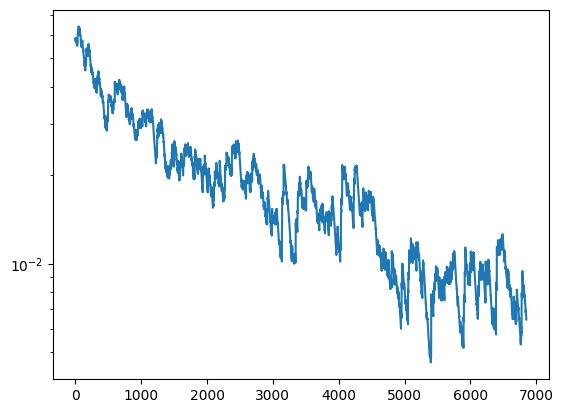

100%|██████████| 3434/3434 [04:15<00:00, 13.43it/s]


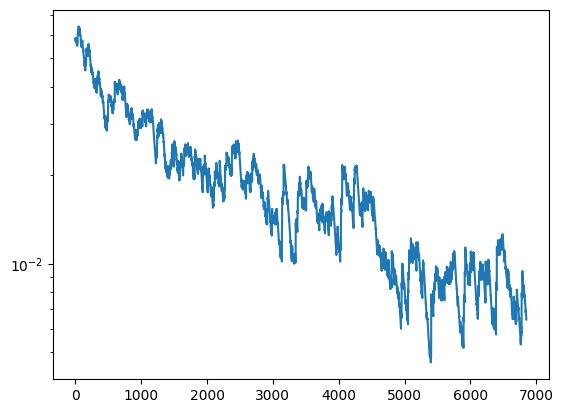

In [49]:
#Train the standard CNN

# Training hyperparameters
params = dict(
  batch_size = 32,
  num_epochs = 2,  # keep small to run faster
  learning_rate = 5e-4,
)

optimizer = tf.keras.optimizers.Adam(params["learning_rate"])
loss_history = mdl.util.LossHistory(smoothing_factor=0.99)
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear()

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = standard_classifier(x)
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

# The training loop!
step = 0
for epoch in range(params["num_epochs"]):
  for idx in tqdm(range(loader.get_train_size()//params["batch_size"])):
    # Grab a batch of training data and propagate through the network
    x, y = loader.get_batch(params["batch_size"])
    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())
    step += 1

In [50]:
# Evaluation of standard CNN
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

157/157 [==============================] - 6s 34ms/step
Standard CNN accuracy on (potentially biased) training set: 0.9968


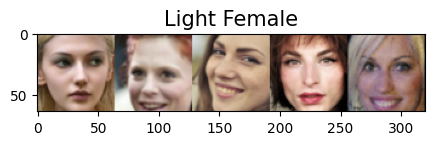

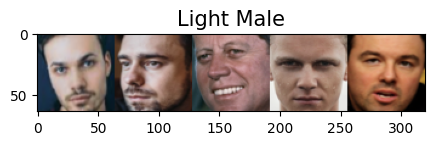

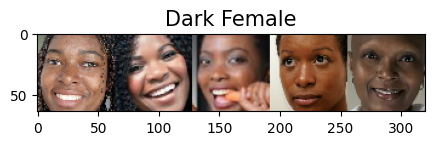

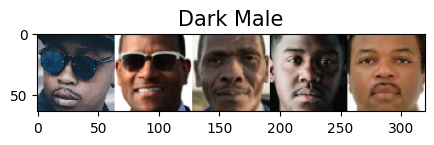

In [51]:
# Load test dataset and plot examples
test_faces = mdl.lab2.get_test_faces()
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
for group, key in zip(test_faces,keys):
  plt.figure(figsize=(5,5))
  plt.imshow(np.hstack(group))
  plt.title(key, fontsize=15)

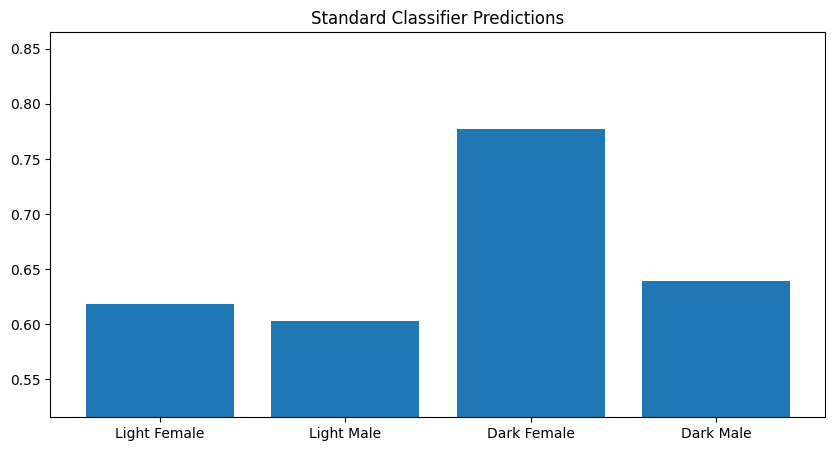

In [52]:
# Evaluate the standard CNN on the test data
# Evaluate the probability of each of these face demographics being classified as a face using the standard CNN classifier we've just trained.
standard_classifier_logits = []
for x in test_faces:
    logits = standard_classifier(np.array(x, dtype=np.float32))
    standard_classifier_logits.append(logits)

# Convert logits to probabilities using sigmoid activation
standard_classifier_probs = tf.squeeze(tf.sigmoid(standard_classifier_logits))

# Calculate mean prediction probabilities per demographic
demographic_accuracies = standard_classifier_probs.numpy().mean(axis=1)

# Plot the prediction accuracies per demographic
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(range(len(keys)), demographic_accuracies)
ax.set_xticks(range(len(keys)))
ax.set_xticklabels(keys)
ax.set_ylim(max(0, demographic_accuracies.min() - demographic_accuracies.ptp() / 2),
            demographic_accuracies.max() + demographic_accuracies.ptp() / 2)
ax.set_title("Standard Classifier Predictions")
plt.show()

Imbalances in the training data can lead to undesirable algorithmic bias. For instance, the majority of faces in the CelebA dataset (our training set) are those of light-skinned females. Consequently, a classifier trained on CelebA will be more effective at recognizing and classifying faces with similar features, resulting in bias.

A straightforward solution involves annotating different subclasses within the training data (e.g., light-skinned females, males with hats, etc.) and then manually balancing the data across these groups.

However, this approach has two significant drawbacks. Firstly, annotating large volumes of data is not scalable. Secondly, it requires prior knowledge of potential biases (e.g., race, gender, pose, occlusion, hats, glasses, etc.) to look for in the data. As a result, manual annotation may not capture all the various imbalanced features within the training data.

Instead, one can **learn** these features in an unbiased, unsupervised manner, eliminating the need for any annotation, and then train a classifier fairly with respect to these features.

#**Variational autoencoder (VAE) for learning latent structure**

-- The CNN's accuracy varies across the four demographics, as we observed the case above. To understand why this occurs, consider the CelebA dataset used for training the model. If certain features, such as dark skin or hats, are *rare* in CelebA, the model may become biased against these features due to training on a biased dataset. Consequently, its classification accuracy will be poorer on faces with under-represented features, such as dark-skinned faces or faces with hats, compared to faces with features well-represented in the training data.

-- Our objective is to train a *debiased* version of this classifier—one that addresses potential disparities in feature representation within the training data. Specifically, to build a debiased facial classifier, we will train a model that **learns a representation of the underlying latent space** in the face training data. The model then uses this information to mitigate unwanted biases by sampling faces with rare features, like dark skin or hats, *more frequently* during training. The crucial design requirement for our model is its ability to learn an *encoding* of the latent features in the face data in an entirely *unsupervised* manner. To achieve this, one can use variational autoencoders (VAEs).


-- Variational Autoencoders (VAEs) use an encoder-decoder architecture to learn a latent representation of input data. In the computer vision, the encoder network processes input images, encoding them into a set of variables characterized by a mean and standard deviation. It then samples from the distributions defined by these parameters to produce a set of latent variables. The decoder network subsequently "decodes" these variables to reconstruct the original image. This reconstruction process is used during training to help the model determine which latent variables are important to learn.




### VAEs: Loss Function

How do we train a Variational Autoencoder (VAE) in practice? While learning the latent space, we ensure that the means and standard deviations adhere closely to a unit Gaussian distribution. These are learned parameters, so they must be included in the loss calculation. Additionally, the decoder part of the VAE uses these parameters to generate a reconstruction that should closely resemble the input image, which also needs to be factored into the loss. This results in two components in our VAE loss function:

1. **Latent Loss ($L_{KL}$)**: This term measures how well the learned latent variables conform to a unit Gaussian distribution and is calculated using the Kullback-Leibler (KL) divergence.
2. **Reconstruction Loss ($L_{x}{(x,\hat{x})}$)**: This term evaluates how accurately the reconstructed output matches the input. It is calculated using the $L^1$ norm between the input image and its reconstructed counterpart.

In [53]:
### Defining the VAE Loss Function ###

def calculate_vae_loss(inputs, reconstructed, mu, log_sigma, kl_weight=0.0005):
    """
    Calculate the VAE loss given:
        inputs: Original input data
        reconstructed: Reconstructed output data
        mu: Encoded means
        log_sigma: Encoded log of standard deviations
        kl_weight: Weight parameter for the latent loss (KL divergence)
    """

    # Latent loss using Kullback-Leibler (KL) divergence
    kl_divergence = 0.5 * tf.reduce_sum(tf.exp(log_sigma) + tf.square(mu) - 1.0 - log_sigma, axis=1)

    # Reconstruction loss as the mean absolute pixel-wise difference between input and reconstruction
    reconstruction_loss = tf.reduce_mean(tf.abs(inputs - reconstructed), axis=(1, 2, 3))

    # Combined VAE loss
    total_vae_loss = kl_weight * kl_divergence + reconstruction_loss

    return total_vae_loss



### VAEs: Reparameterization

Variational Autoencoders (VAEs) employ a "reparameterization trick" to sample the learned latent variables. Instead of the VAE encoder producing a single vector of real numbers for each latent variable, it generates vectors of means ($\mu$) and standard deviations ($\sigma$) that are constrained to approximately follow Gaussian distributions. We then sample from these standard deviations and add the mean to obtain our sampled latent vector. Mathematically, for a latent variable \( z \) where we sample $\epsilon\sim N(0, I)$, this can be expressed as:

$$z = \mu + e^{\left(\frac{1}{2} \cdot \log{\sigma^2}\right)} \cdot \epsilon$$

where $\mu$ represents the mean and $\sigma^2$ denotes the variance. This approach is advantageous because it enables us to:

1. Define the VAE loss function in a structured manner.
2. Generate random samples of latent variables.
3. Enhance network generalization.
4. Maintain the differentiability of the entire VAE network, allowing training via backpropagation.


In [54]:
# VAE Reparameterization
def sample_latent_vector(z_mean, z_logsigma):
    """
    Reparameterization trick by sampling from an isotropic unit Gaussian.

    Args:
        z_mean (tensor): Mean of the latent distribution Q(z|X)
        z_logsigma (tensor): Log of the standard deviation of the latent distribution Q(z|X)

    Returns:
        z (tensor): Sampled latent vector
    """
    epsilon = tf.random.normal(shape=tf.shape(z_mean))  # Sample from standard normal distribution
    z = z_mean + tf.exp(0.5 * z_logsigma) * epsilon  # Reparameterization trick
    return z

### The DB-VAE Model

The central concept of this debiasing method is to use the latent variables learned through a VAE to adaptively re-sample the CelebA dataset during training. Specifically, we will adjust the likelihood of a given image being used in training based on the frequency of its latent features in the dataset. Consequently, faces with rarer features (such as dark skin, sunglasses, or hats) will have a higher probability of being sampled during training. Conversely, the sampling probability for faces with features that are over-represented in the training dataset will decrease (compared to uniform random sampling across the training data).

### Defining the DB-VAE Loss Function

Creating the loss function for the DB-VAE requires a nuanced approach, as it varies depending on whether the image is a face or a non-face.

For **face images**, the loss function comprises two parts:

1. **VAE Loss ($L_{VAE}$)**: This includes both the latent loss and the reconstruction loss.
2. **Classification Loss ($L_y(y, \hat{y})$)**: The standard cross-entropy loss used for binary classification.

For **non-face images**, the loss function consists solely of the classification loss.

To unify these cases, we can define an indicator variable $I_f$ that distinguishes between face images ($I_f(y) = 1$) and non-face images ($I_f(y) = 0$). Using this indicator, the total loss can be expressed as:

$$L_{total} = L_y(y, \hat{y}) + I_f(y) \cdot L_{VAE}$$


In [56]:
# Loss Function for DB-VAE

def debiasing_loss_function(inputs, reconstructed, labels, logits, mean, log_sigma):
    """
    Compute the DB-VAE loss.

    Args:
        inputs (tensor): Original input images.
        reconstructed (tensor): Reconstructed images.
        labels (tensor): True labels (face or non-face).
        logits (tensor): Predicted logits.
        mean (tensor): Mean of the latent distribution (Q(z|X)).
        log_sigma (tensor): Logarithm of the standard deviation of the latent distribution (Q(z|X)).

    Returns:
        total_loss (tensor): Combined DB-VAE total loss.
        classification_loss (tensor): DB-VAE classification loss.
    """
    # Calculate the VAE loss
    vae_loss = calculate_vae_loss(inputs, reconstructed, mean, log_sigma)

    # Compute the classification loss using sigmoid cross-entropy
    classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)

    # Indicator variable to determine if the data is a face image
    is_face = tf.cast(tf.equal(labels, 1), tf.float32)

    # Calculate the total DB-VAE loss
    total_loss = tf.reduce_mean(classification_loss + is_face * vae_loss)

    return total_loss, classification_loss


In [57]:
from tensorflow.keras import layers, Sequential

n_filters = 12  # Base number of convolutional filters, same as standard CNN
latent_dim = 100  # Number of latent variables

def create_face_decoder():
    """
    Creates the decoder network for the DB-VAE.

    Returns:
        decoder (tf.keras.Model): The decoder model.
    """
    # Define the decoder network using the Sequential API
    decoder = Sequential()

    # Dense layer to transform the input to the pre-convolutional generation
    decoder.add(layers.Dense(4 * 4 * 6 * n_filters, activation='relu', input_shape=(latent_dim,)))
    decoder.add(layers.Reshape((4, 4, 6 * n_filters)))

    # Upscaling convolutions (inverse of encoder)
    decoder.add(layers.Conv2DTranspose(4 * n_filters, kernel_size=3, strides=2, padding='same', activation='relu'))
    decoder.add(layers.Conv2DTranspose(2 * n_filters, kernel_size=3, strides=2, padding='same', activation='relu'))
    decoder.add(layers.Conv2DTranspose(n_filters, kernel_size=5, strides=2, padding='same', activation='relu'))
    decoder.add(layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='relu'))

    return decoder

In [59]:
class DB_VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(DB_VAE, self).__init__()
        self.latent_dim = latent_dim

        # Define the number of outputs for the encoder: latent_dim latent variables and a supervised output
        num_encoder_dims = 2 * self.latent_dim + 1

        self.encoder = create_cnn_model(num_encoder_dims)
        self.decoder = create_face_decoder()

    def encode(self, x):
        """
        Feed images into encoder, encode the latent space, and output classification probability.

        Args:
            x (tensor): Input images

        Returns:
            y_logit (tensor): Classification logits
            z_mean (tensor): Mean of latent variables
            z_logsigma (tensor): Log of standard deviation of latent variables
        """
        encoder_output = self.encoder(x)
        y_logit = tf.expand_dims(encoder_output[:, 0], axis=-1)
        z_mean = encoder_output[:, 1:self.latent_dim+1]
        z_logsigma = encoder_output[:, self.latent_dim+1:]
        return y_logit, z_mean, z_logsigma

    def reparameterize(self, z_mean, z_logsigma):
        """
        VAE reparameterization: given a mean and logsigma, sample latent variables.

        Args:
            z_mean (tensor): Mean of latent variables
            z_logsigma (tensor): Log of standard deviation of latent variables

        Returns:
            z (tensor): Sampled latent variables
        """
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        z = z_mean + tf.exp(0.5 * z_logsigma) * epsilon
        return z

    def decode(self, z):
        """
        Decode the latent space and output reconstruction.

        Args:
            z (tensor): Latent variables

        Returns:
            reconstruction (tensor): Reconstructed images
        """
        reconstruction = self.decoder(z)
        return reconstruction

    def call(self, x):
        """
        Pass inputs through the VAE.

        Args:
            x (tensor): Input images

        Returns:
            y_logit (tensor): Classification logits
            z_mean (tensor): Mean of latent variables
            z_logsigma (tensor): Log of standard deviation of latent variables
            recon (tensor): Reconstructed images
        """
        y_logit, z_mean, z_logsigma = self.encode(x)
        z = self.reparameterize(z_mean, z_logsigma)
        recon = self.decode(z)
        return y_logit, z_mean, z_logsigma, recon

    def predict(self, x):
        """
        Predict face or non-face logit for given input.

        Args:
            x (tensor): Input images

        Returns:
            y_logit (tensor): Classification logits
        """
        y_logit, _, _ = self.encode(x)
        return y_logit

# Instantiate the DB-VAE model
latent_dim = 100  # Define the latent dimension
dbvae = DB_VAE(latent_dim)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Adaptive Resampling for Automated Debiasing with DB-VAE

How can we leverage DB-VAE to train a debiased facial detection classifier?

Consider the DB-VAE architecture: as input images pass through the network, the encoder learns an estimate \( Q(z|X) \) of the latent space. Our goal is to increase the sampling frequency of rare data by focusing more on under-represented regions of the latent space. We can approximate \( Q(z|X) \) using the frequency distributions of each learned latent variable. Based on this approximation, we can define the probability distribution for selecting a given data point \( x \). These probability distributions will then be utilized during training to re-sample the data.

In [60]:
# Function to return the means for an input image batch
def get_latent_mu(images, dbvae, batch_size=1024):
  N = images.shape[0]
  mu = np.zeros((N, latent_dim))
  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)/255.
    _, batch_mu, _ = dbvae.encode(batch)
    mu[start_ind:end_ind] = batch_mu
  return mu

In [61]:
# Resampling Algorithm for DB-VAE

def compute_sampling_probabilities(images, dbvae, bins=10, smoothing_factor=0.001):
    """
    Recompute the sampling probabilities for images within a batch based on their distribution across the training data.

    Args:
        images (np.array): Batch of images.
        dbvae (DB_VAE): The DB-VAE model.
        bins (int): Number of bins for histogram.
        smoothing_factor (float): Smoothing factor for histogram density.

    Returns:
        training_sample_probabilities (np.array): Array of sampling probabilities for the images.
    """
    print("Recomputing the sampling probabilities")

    # Get the latent variable means for the input batch
    latent_means = get_latent_mu(images, dbvae)

    # Initialize sampling probabilities for the images
    training_sample_probabilities = np.zeros(latent_means.shape[0])

    # Iterate over each latent dimension
    for i in range(latent_dim):
        latent_distribution = latent_means[:, i]

        # Generate a histogram of the latent distribution
        hist_density, bin_edges = np.histogram(latent_distribution, density=True, bins=bins)

        # Adjust bin edges for digitize function
        bin_edges[0], bin_edges[-1] = -float('inf'), float('inf')

        # Find which bin each data sample falls into
        bin_indices = np.digitize(latent_distribution, bin_edges)

        # Smooth the density function
        smoothed_density = hist_density + smoothing_factor
        smoothed_density /= np.sum(smoothed_density)

        # Invert the density function to get probabilities
        probabilities = 1.0 / smoothed_density[bin_indices - 1]

        # Normalize probabilities
        probabilities /= np.sum(probabilities)

        # Update sampling probabilities with the maximum value
        training_sample_probabilities = np.maximum(probabilities, training_sample_probabilities)

    # Final normalization of sampling probabilities
    training_sample_probabilities /= np.sum(training_sample_probabilities)

    return training_sample_probabilities


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Starting epoch 1/1
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

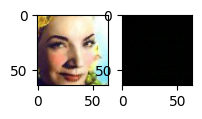

 15%|█▍        | 500/3434 [01:05<05:26,  9.00it/s]

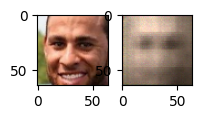

 29%|██▉       | 1000/3434 [02:05<06:44,  6.01it/s]

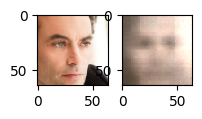

 44%|████▎     | 1500/3434 [03:06<03:38,  8.85it/s]

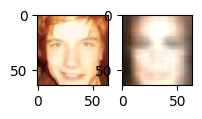

 58%|█████▊    | 2000/3434 [04:06<02:30,  9.52it/s]

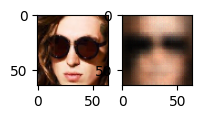

 73%|███████▎  | 2500/3434 [05:07<01:38,  9.47it/s]

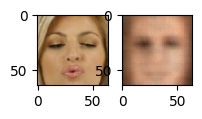

 87%|████████▋ | 3000/3434 [06:08<00:46,  9.32it/s]

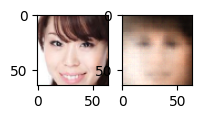

100%|██████████| 3434/3434 [07:14<00:00,  7.90it/s]


In [62]:
# Training the DB-VAE

# Hyperparameters
params = {
    "batch_size": 32,
    "learning_rate": 5e-4,
    "latent_dim": 100,
    "num_epochs": 1,  # DB-VAE needs slightly more epochs to train
}

# Instantiate a new DB-VAE model and optimizer
dbvae_model = DB_VAE(params["latent_dim"])
optimizer = tf.keras.optimizers.Adam(learning_rate=params["learning_rate"])

# Define the training step using tf.function to create a TensorFlow computation graph
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        # Forward pass through the DB-VAE model
        logits, mean, logsigma, reconstruction = dbvae_model(inputs)
        # Compute the loss
        total_loss, classification_loss = debiasing_loss_function(inputs, reconstruction, labels, logits, mean, logsigma)
    # Compute the gradients
    gradients = tape.gradient(total_loss, dbvae_model.trainable_variables)
    # Apply the gradients to the optimizer
    optimizer.apply_gradients(zip(gradients, dbvae_model.trainable_variables))
    return total_loss

# Retrieve all training face images from the data loader
all_training_faces = loader.get_all_train_faces()

# Clear existing tqdm instances if they exist
if hasattr(tqdm, '_instances'): tqdm._instances.clear()

# Training loop
step = 0
for epoch in range(params["num_epochs"]):
    IPython.display.clear_output(wait=True)
    print(f"Starting epoch {epoch + 1}/{params['num_epochs']}")

    # Recompute sampling probabilities for debiasing
    sampling_probabilities = compute_sampling_probabilities(all_training_faces, dbvae_model)

    # Inner loop iterates over batches
    for batch_idx in tqdm(range(loader.get_train_size() // params["batch_size"])):
        # Load a batch of training data
        batch_inputs, batch_labels = loader.get_batch(params["batch_size"], p_pos=sampling_probabilities)

        # Perform a training step
        loss = train_step(batch_inputs, batch_labels)

        # Plot the progress every 500 steps
        if batch_idx % 500 == 0:
            mdl.util.plot_sample(batch_inputs, batch_labels, dbvae_model)

        step += 1


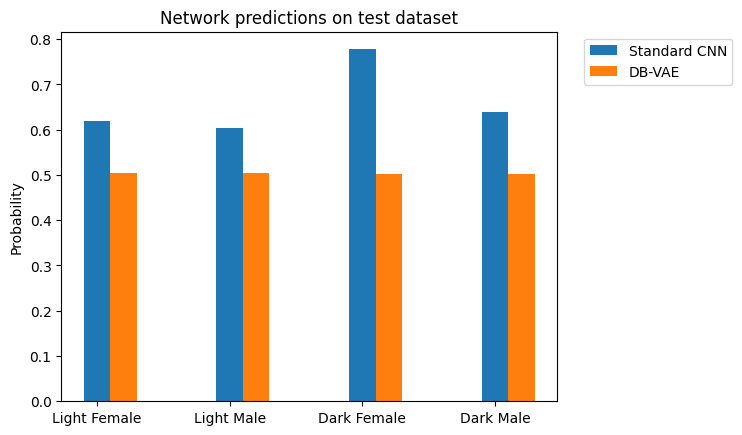

In [63]:
dbvae_logits = [dbvae.predict(np.array(x, dtype=np.float32)) for x in test_faces]
dbvae_probs = tf.squeeze(tf.sigmoid(dbvae_logits))

xx = np.arange(len(keys))
plt.bar(xx, standard_classifier_probs.numpy().mean(1), width=0.2, label="Standard CNN")
plt.bar(xx+0.2, dbvae_probs.numpy().mean(1), width=0.2, label="DB-VAE")
plt.xticks(xx, keys);
plt.title("Network predictions on test dataset")
plt.ylabel("Probability"); plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");


Thanks to
© MIT 6.S191: Introduction to Deep Learning http://introtodeeplearning.com

for great lectures, slides and projects to apply our knwoledge in practical situations.